# Quadratic Reward Analysis
#### Analyse the cause of steady state error

In [1]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from os import path
from scipy.integrate import solve_ivp
import pandas as pd

import gym_gyroscope_env
import spinup
import torch
from functools import partial

from custom_functions.custom_functions import env_fn 
from custom_functions.custom_functions import create_env
from custom_functions.custom_functions import load_agent
from custom_functions.custom_functions import test_agent
from custom_functions.custom_functions import plot_test
from custom_functions.custom_functions import evaluate_control
from custom_functions.custom_functions import angle_normalize

import random
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Initialization args
env_name = 'GyroscopeEnv-v1'
simu_args = {
    'dt': 0.05,
    'ep_len': 100,
    'seed': 2
}
reward_func = 'Quadratic'
reward_args = {
    'qx1': 1, 
    'qx2': 0, 
    'qx3': 1, 
    'qx4': 0, 
    'pu1': 0, 
    'pu2': 0
}
# reward_func = 'Exponential'
# reward_args = {
#     'qx1': 1, 
#     'qx2': 0, 
#     'qx3': 1, 
#     'qx4': 0, 
#     'pu1': 0, 
#     'pu2': 0,
#     'e': 40
# }
# reward_func = 'Power'
# reward_args = {
#     'qx1': 1, 
#     'qx2': 0, 
#     'qx3': 1, 
#     'qx4': 0, 
#     'pu1': 0, 
#     'pu2': 0,
#     'p': 0.05
# }

state = np.array([0,0,0,0,45/180*np.pi,-60/180*np.pi,200/60*2*np.pi])
env = create_env(env_name,simu_args,reward_func,reward_args,state=state)

In [3]:
t_end = 100
agent_paths = ['ddpg_e20', 'linearized controller']

env.reset(state)
agent_1 = load_agent(agent_paths[0])
score_1, state_record_1, obs_record_1, action_record_1, reward_record_1 = test_agent(env,agent_1,t_end)

env.reset(state)
agent_2 = load_agent(agent_paths[1])
score_2, state_record_2, obs_record_2, action_record_2, reward_record_2 = test_agent(env,agent_2,t_end)

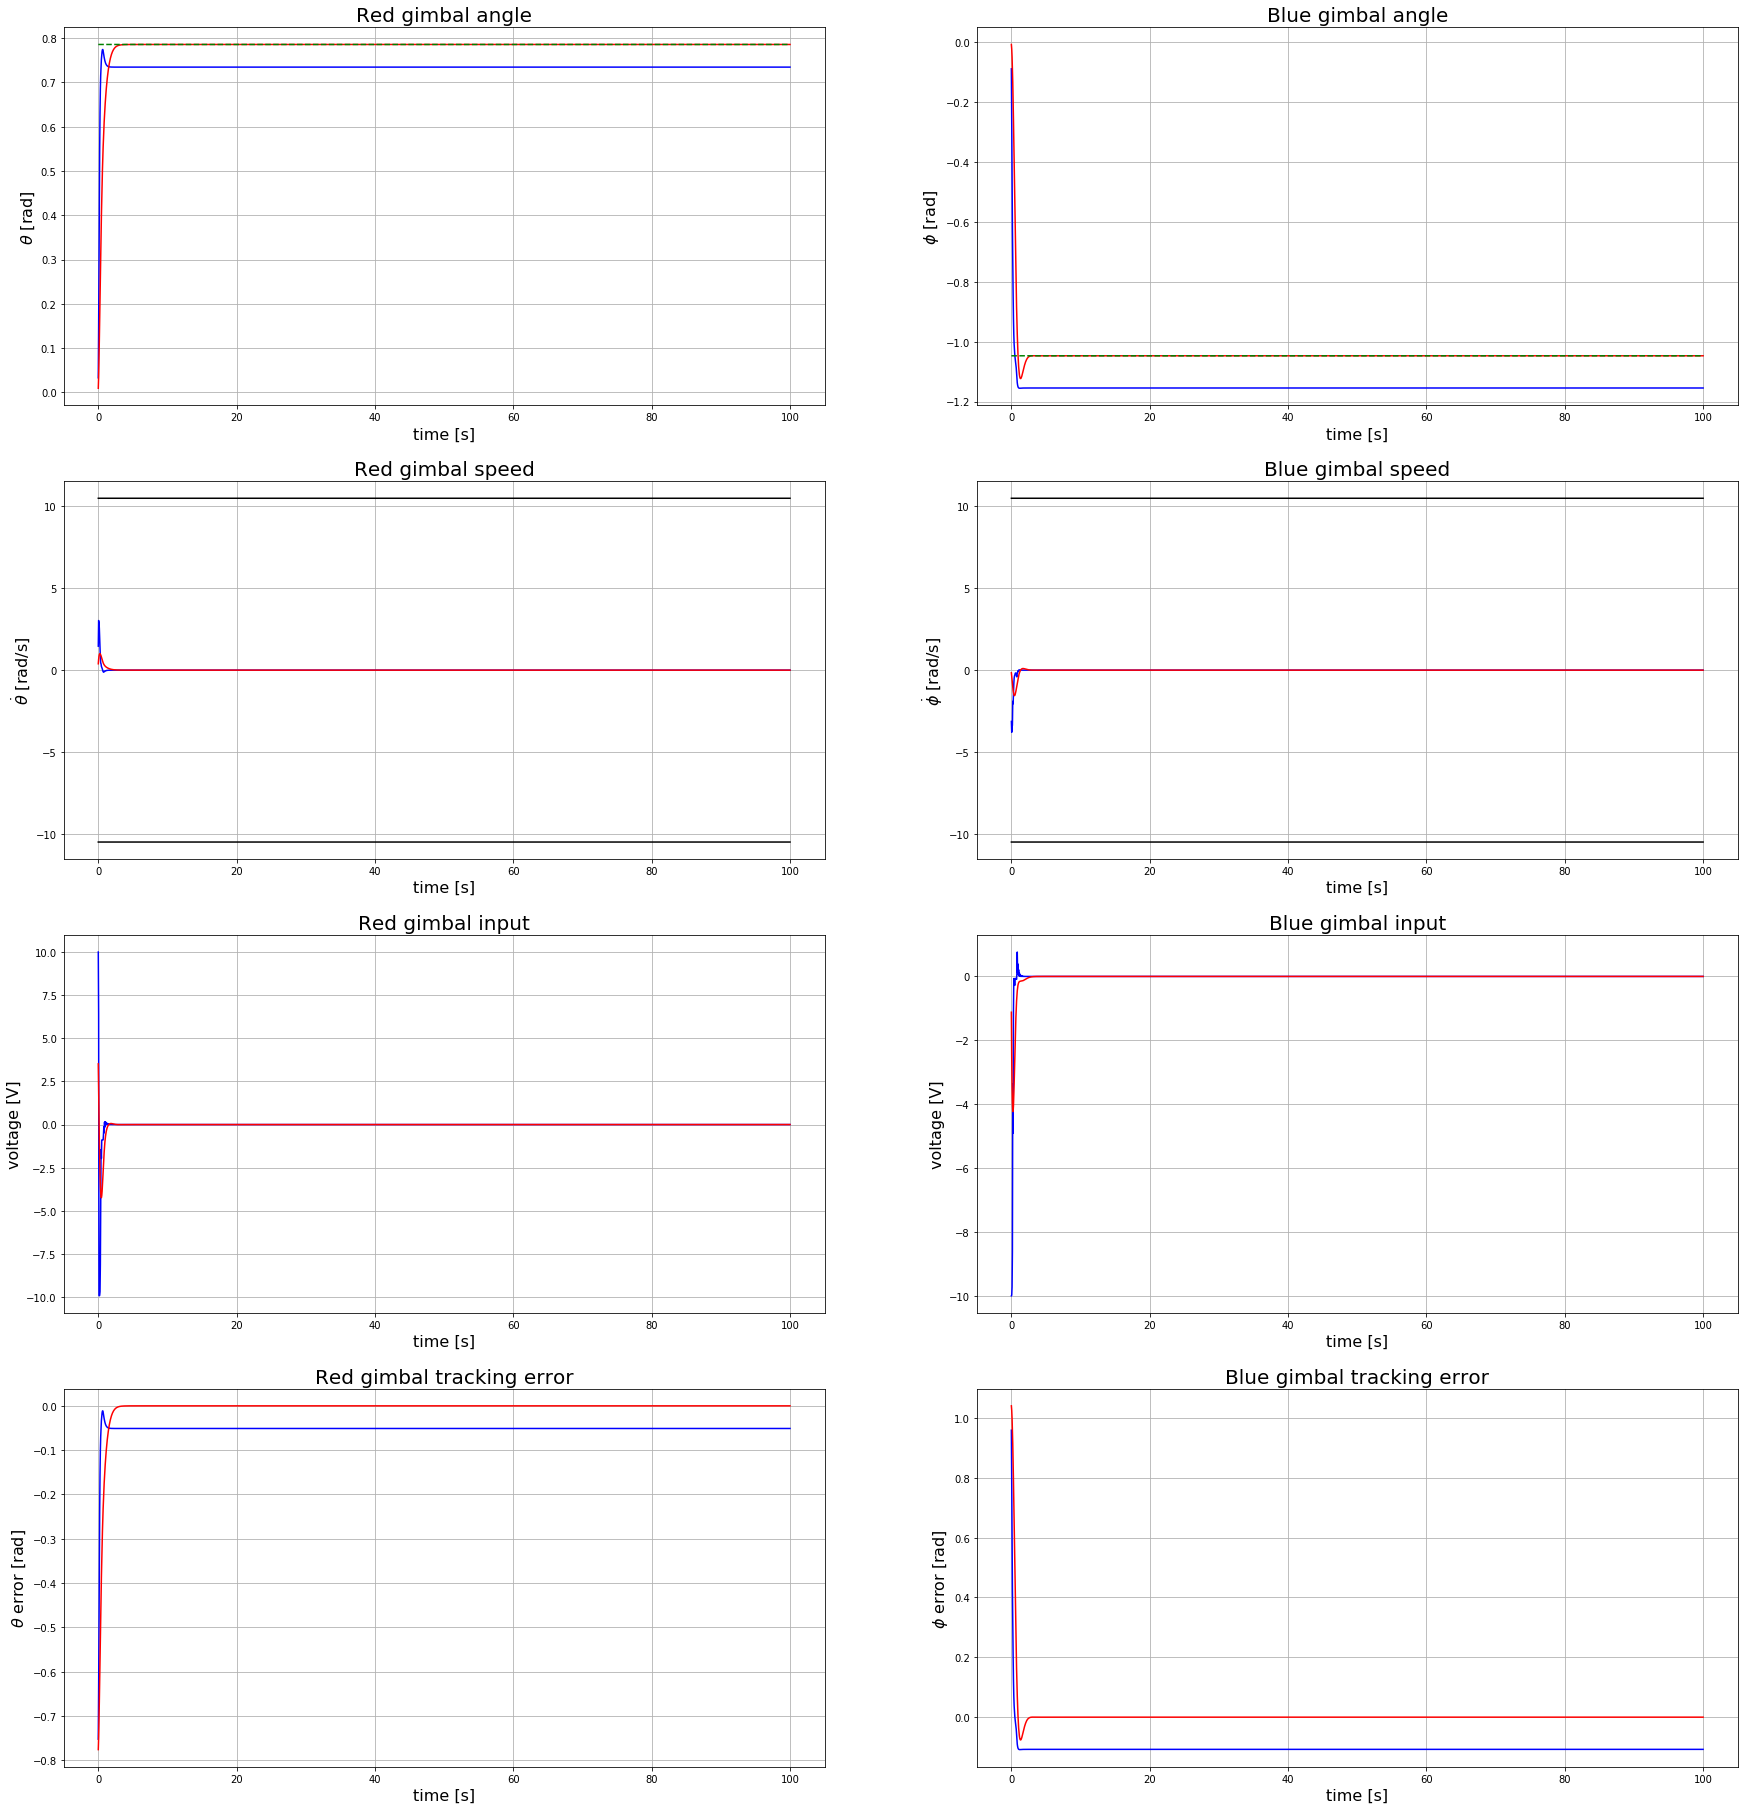

In [4]:
n = 4
time = np.linspace(0, t_end, len(state_record_1))

f, axs = plt.subplots(n,2,figsize=(30,8*n))

plt.subplot(n,2,1)
plt.title('Red gimbal angle',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel(r'$\theta$ [rad]',fontsize=16)
plt.grid()
plt.plot(time,angle_normalize(state_record_1[:,0]),'b-')
plt.plot(time,angle_normalize(state_record_2[:,0]),'r-')
plt.plot(time,angle_normalize(state_record_1[:,4]),'g--')
# plt.plot(time,np.full(len(time),180), 'k-')
# plt.plot(time,np.full(len(time),-180), 'k-')

plt.subplot(n,2,2)
plt.title('Blue gimbal angle',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel(r'$\phi$ [rad]',fontsize=16)
plt.grid()
plt.plot(time,angle_normalize(state_record_1[:,2]),'b-')
plt.plot(time,angle_normalize(state_record_2[:,2]),'r-')
plt.plot(time,angle_normalize(state_record_1[:,5]),'g--')
# plt.plot(time,np.full(len(time),180), 'k-')
# plt.plot(time,np.full(len(time),-180), 'k-')

plt.subplot(n,2,3)
plt.title('Red gimbal speed',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel(r'$\dot \theta$ [rad/s]',fontsize=16)
plt.grid()
plt.plot(time,state_record_1[:,1],'b-')
plt.plot(time,state_record_2[:,1],'r-')
plt.plot(time,np.full(len(time),200/60*np.pi), 'k-')
plt.plot(time,np.full(len(time),-200/60*np.pi), 'k-')

plt.subplot(n,2,4)
plt.title('Blue gimbal speed',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel(r'$\dot \phi$ [rad/s]',fontsize=16)
plt.grid()
plt.plot(time,state_record_1[:,3],'b-')
plt.plot(time,state_record_2[:,3],'r-')
plt.plot(time,np.full(len(time),200/60*np.pi), 'k-')
plt.plot(time,np.full(len(time),-200/60*np.pi), 'k-')

plt.subplot(n,2,5)
plt.title('Red gimbal input',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel('voltage [V]',fontsize=16)
plt.grid()
plt.plot(time,action_record_1[:,0]*10,'b-')
plt.plot(time,action_record_2[:,0]*10,'r-')

plt.subplot(n,2,6)
plt.title('Blue gimbal input',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel('voltage [V]',fontsize=16)
plt.grid()
plt.plot(time,action_record_1[:,1]*10,'b-')
plt.plot(time,action_record_2[:,1]*10,'r-')

plt.subplot(n,2,7)
plt.title('Red gimbal tracking error',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel(r'$\theta$ error [rad]',fontsize=16)
plt.grid()
plt.plot(time,angle_normalize(state_record_1[:,0]-state_record_1[:,4]),'b-')
plt.plot(time,angle_normalize(state_record_2[:,0]-state_record_2[:,4]),'r-')

plt.subplot(n,2,8)
plt.title('Blue gimbal tracking error',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel(r'$\phi$ error [rad]',fontsize=16)
plt.grid()
plt.plot(time,angle_normalize(state_record_1[:,2]-state_record_1[:,5]),'b-')
plt.plot(time,angle_normalize(state_record_2[:,2]-state_record_2[:,5]),'r-')

plt.show()

#### Now recompute the reward for an integral env

In [5]:
env_name = 'GyroscopeIntegralEnv-v1'
reward_func = 'Quadratic'
reward_args = {
    'qx1': 9, 
    'qx2': 0.05, 
    'qx3': 9, 
    'qx4': 0.05, 
    'qi1': 100,
    'qi3': 100,
    'pu1': 0.1, 
    'pu2': 0.1
}
state = np.array([0,0,0,0,45/180*np.pi,-60/180*np.pi,200/60*2*np.pi])
env = create_env(env_name,simu_args,reward_func,reward_args,state=state)

# RL controller
x1_diff_int = x3_diff_int = 0
x1_diff_int_RL, x3_diff_int_RL = np.zeros((len(time),1)), np.zeros((len(time),1))
for i in range(len(time)):
    
    x1, x2, x3, x4, x1_ref, x3_ref, w = state_record_1[i]
    a1, a2 = action_record_1[i]
    
    # Angle error (normalized between pi and -pi to get smallest distance)
    x1_diff = env.angle_normalize(x1 - x1_ref)
    x3_diff = env.angle_normalize(x3 - x3_ref)
        
    # Integrals
    x1_diff_int += x1 - x1_ref
    x3_diff_int += x3 - x3_ref
    x1_diff_int_RL[i] = x1_diff_int
    x3_diff_int_RL[i] = x3_diff_int
    
    # Reward(float), normalized everything in advance
    reward_record_1[i] = env.reward_func(x1_diff/env.maxAngle, x3_diff/env.maxAngle, 
                                          x2/env.maxGimbalSpeed, x4/env.maxGimbalSpeed, 0, 0,
                                          np.sign(x1_diff_int)*abs(x1_diff_int)/(1+abs(x1_diff_int)), 
                                          np.sign(x3_diff_int)*abs(x3_diff_int)/(1+abs(x3_diff_int)),
                                          a1, a2, **env.reward_args)
    
# FL controller
x1_diff_int = x3_diff_int = 0
x1_diff_int_FL, x3_diff_int_FL = np.zeros((len(time),1)), np.zeros((len(time),1))
for i in range(len(time)):
    
    x1, x2, x3, x4, x1_ref, x3_ref, w = state_record_2[i]
    a1, a2 = action_record_2[i]
    
    # Angle error (normalized between pi and -pi to get smallest distance)
    x1_diff = env.angle_normalize(x1 - x1_ref)
    x3_diff = env.angle_normalize(x3 - x3_ref)
        
    # Integrals
    x1_diff_int += x1 - x1_ref
    x3_diff_int += x3 - x3_ref
    x1_diff_int_FL[i] = x1_diff_int
    x3_diff_int_FL[i] = x3_diff_int
    
    # Reward(float), normalized everything in advance
    reward_record_2[i] = env.reward_func(x1_diff/env.maxAngle, x3_diff/env.maxAngle, 
                                          x2/env.maxGimbalSpeed, x4/env.maxGimbalSpeed, 0, 0,
                                          np.sign(x1_diff_int)*abs(x1_diff_int)/(1+abs(x1_diff_int)), 
                                          np.sign(x3_diff_int)*abs(x3_diff_int)/(1+abs(x3_diff_int)),
                                          a1, a2, **env.reward_args)

#### Similar result is observed: the RL controller prefer a fast trajectory but leads to ss error

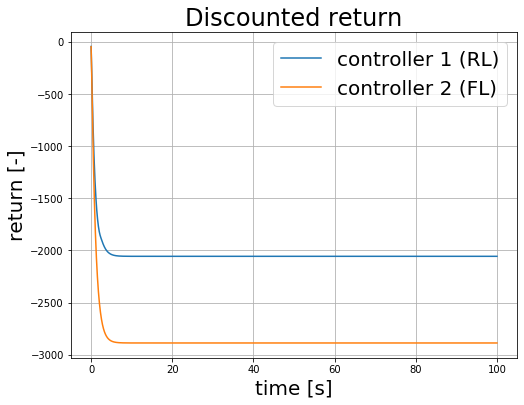

In [16]:
gamma = 0.95

return_record_1 = np.copy(reward_record_1)
for i in range(1, len(time)):
    return_record_1[i] = return_record_1[i] * gamma**i + return_record_1[i-1]

return_record_2 = np.copy(reward_record_2)
for i in range(1, len(time)):
    return_record_2[i] = return_record_2[i] * gamma**i + return_record_2[i-1]

plt.figure(figsize=(8,6))
plt.title('Discounted return',fontsize=24)
plt.xlabel('time [s]',fontsize=20)
plt.ylabel('return [-]',fontsize=20)
plt.grid()
# plt.plot(time,x1_diff_int_RL)
# plt.plot(time,x3_diff_int_RL)
# plt.plot(time,x1_diff_int_FL)
# plt.plot(time,x3_diff_int_FL)
# plt.plot(time,reward_record_1)
# plt.plot(time,reward_record_2)
plt.plot(time,return_record_1)
plt.plot(time,return_record_2)
plt.legend(['controller 1 (RL)', 'controller 2 (FL)'],fontsize=20)

plt.savefig('compare_int.png')